## Introduction

In this notebook, we will use tools like scikit, geopy, the Foursquare API and others, to analyze the neighborhoods of the city of Sao Paulo, in Brazil. More specifically, we will discuss the types of public and private venues available at different regions of the city and check how this data relates with key indicators like GDP per capita, HDI, criminality and others.

The two main stakeholders that can benefit from such analysis are (i) the public agents (mayor, governor, deputies, etc.), who can use the data to justify future plans to actions aimed to reduce inequality and improve living standards of the poorest; and (ii) the inhabitants of the city (my fellow “Paulistanos”, or Sao Paulo citizens), which may use the data to better understand some peculiarities of the city they live in, as well as to evaluate the work of the politicians and demand better actions. Surely enough, the following analysis is only introductory and fruit of a couple of weeks’ work. Nevertheless, it still brings some data and information that may be useful, at least as the basis for more detailed work.

## Data

Let's start by importing the necessary modules:

- Requests and urllib, to allow inquiring data from websites
- Geopy, to get spatial coordinates from addresses
- BeautifulSoup, to decode HTML data properly (as addresses are in Portuguese and they include special characters)
- Numpy, Scipy, Pandas, Matplotlib and Scikit-learn for the data preparation and modelling
- Folium, to enable map plotting
- Random and time standard libraries

In [2]:
import requests
from geopy.geocoders import Nominatim
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import scipy as sc
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import time
import cv2
import folium
import pandas as pd
from folium.plugins import MarkerCluster
from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit
from scipy import stats

CLIENT_ID = '2REBOOS3YFKNJDH4PVUAELAGFULDILSOVRNYA2OXOP3TH0GC' # your Foursquare ID
CLIENT_SECRET = 'HUYA1HXT0WXNO2UXSHYT4YD1E3RH2AID0IVAUBT41CTQDZR5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Getting neighborhoods central coordinates

Next, we will access the coordinates of each neighborhood in the city - in Sao Paulo, they are called "subprefeituras". In the website below, we can find the address of the central administration of each neighborhood:

https://32xsp.org.br/2018/09/06/telefones-das-subprefeituras-de-sao-paulo/index.php

Let's then decode the HTML of this website to gather the address of each neighborhood's administration building, whose coordinates we will consider the center of the neighborhood:

In [3]:
# dictionary to allocate the address and coordinates of each 'subprefeitura'
subpref_addresses = {}

# gathering address of each neighborhood from the website below:
req = Request('https://32xsp.org.br/2018/09/06/telefones-das-subprefeituras-de-sao-paulo/index.php', headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
webpage = BeautifulSoup(webpage)

# removing unnecessary information and keeping only the address data
webpage = str(webpage).split("<p><strong>SUBPREFEITURAS</strong></p>")[1]
webpage = webpage.split("<p><em>Com informações da")[0]
subpref_gross_list = webpage.split("<p><strong>")[1:]

geolocator = Nominatim(user_agent="IBM_Data_Science")

# for each neighborhood, decoding the address data, reading the coordinates and filling the dictionary
for subpref_data in subpref_gross_list:
    name = subpref_data.split("<br/>")[0]
    address = subpref_data.split("Endereço:</strong>")[1]
    address = address.replace("</p>\n","")
    address = address.replace("\n","")
    address = address.split("–")[0] + ", São Paulo"
    try: location = geolocator.geocode(address)
    except: 
        time.sleep(5)
        location = geolocator.geocode(address)
    try: subpref_addresses[name] = [address, location.latitude, location.longitude]
    except: subpref_addresses[name] = [address, "NONE", "NONE"]

Let's investigate the data we gathered above. First, let's check if all neighborhoods were correctly identified. The city of Sao Paulo has a total of 32 'subprefeituras', as stated in the city official website (in Portuguese):

https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/index.php?p=8978

So, let's investigate the length of the dictionary we just filled above:

In [4]:
len(subpref_addresses)

32

Ok, so the number of the 'subprefeituras' is correct. Now let's check if the data was correctly imported for each of them:

In [5]:
for key in subpref_addresses:
    if "NONE" in subpref_addresses[key]:
        print(','.join([str(key),str(subpref_addresses[key])]))

BUTANTÃ,[' Rua Ulpiano da Costa Manso, 201 , São Paulo', 'NONE', 'NONE']
CIDADE ADEMAR,[' Avenida Yervant Kissajikain, 416 , São Paulo', 'NONE', 'NONE']
ITAIM PAULISTA,[' Avenida Marechal Tito 3012, CEP: 08115-000, São Paulo', 'NONE', 'NONE']
ITAQUERA,[' Rua Augusto Carlos Bauman, 851 CEP: 08210-590, São Paulo', 'NONE', 'NONE']
SÃO MATEUS,[' Rua Ragueb Chohfi, 1.400 , São Paulo', 'NONE', 'NONE']
SÃO MIGUEL,[' Rua Ana Flora Pinheiro de Sousa, 76 , São Paulo', 'NONE', 'NONE']


We can see that, for 6 of the 32 neighborhoods, the coordinates were not correctly identified, even though the address was retrieved correctly. Let's manually fill the coordinates of these 'subprefeituras':

In [6]:
subpref_addresses['BUTANTÃ'][1] = -23.5883813; subpref_addresses['BUTANTÃ'][2] = -46.7402937
subpref_addresses['CIDADE ADEMAR'][1] = -23.6672401; subpref_addresses['CIDADE ADEMAR'][2] = -46.6770408
subpref_addresses['ITAIM PAULISTA'][1] = -23.4943168; subpref_addresses['ITAIM PAULISTA'][2] = -46.419237
subpref_addresses['ITAQUERA'][1] = -23.5316553; subpref_addresses['ITAQUERA'][2] = -46.4494032
subpref_addresses['SÃO MATEUS'][1] = -23.5995437; subpref_addresses['SÃO MATEUS'][2] = -46.4712808
subpref_addresses['SÃO MIGUEL'][1] = -23.4998911; subpref_addresses['SÃO MIGUEL'][2] = -46.4521839

To check that now all the neighborhoods are identified and have the correct coordinates assigned, let's plot a map of Sao Paulo with pins for each of these 'subprefeituras':

In [7]:
# converting the data gathered before into a Pandas dataframe
df_subpref_saopaulo = pd.DataFrame.from_dict(subpref_addresses, orient='index', columns=["Address","Latitude","Longitude"])
df_subpref_saopaulo.index.name = "Neighborhood"

# coordinates of the geometrical center of Sao Paulo
city_latitude = -23.6821604
city_longitude = -46.5754942

# create map of Sao Paulo using latitude and longitude values
map_sao_paulo = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

# add neighborhood markers to map
for lat, lng, neighborhood in zip(df_subpref_saopaulo['Latitude'], 
                                           df_subpref_saopaulo['Longitude'], 
                                           df_subpref_saopaulo.index.values.tolist()):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sao_paulo)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_sao_paulo.add_child(CityLimits)
map_sao_paulo.add_child(folium.map.LayerControl())
    
map_sao_paulo

We see that all of the neighborhood administration addresses fell within the city limits, as expected. One possible problem, though, is that two of the markers are too close from one another, as shown in the picture below. This may be due to an incorrect address or coordinate gathering, as it would not be natural that two 'subprefeituras' offices would be located next to one another:

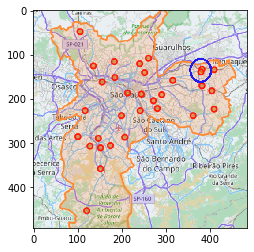

In [8]:
img = cv2.imread('close_neighborhoods.png')
plt.imshow(img)

If we hover through the Folium map, we can see that the two close neighborhoods are "São Miguel" and "Ermelino Matarazzo". A quick search in Google Maps show that, although the address is right, the coordinates for the "Ermelino Matarazzo" neighborhood are wrong. Let's update it manually and replot the map:

In [9]:
subpref_addresses['ERMELINO MATARAZZO'][1] = -23.5077086; subpref_addresses['ERMELINO MATARAZZO'][2] = -46.4817421

df_subpref_saopaulo = pd.DataFrame.from_dict(subpref_addresses, orient='index', columns=["Address","Latitude","Longitude"])
df_subpref_saopaulo.index.name = "Neighborhood"

# coordinates of the geometrical center of Sao Paulo
city_latitude = -23.6821604
city_longitude = -46.5754942

# create map of Sao Paulo using latitude and longitude values
map_sao_paulo = folium.Map(location=[city_latitude,city_longitude], zoom_start=10, width='80%', height='100%')

for lat, lng, neighborhood in zip(df_subpref_saopaulo['Latitude'], 
                                           df_subpref_saopaulo['Longitude'], 
                                           df_subpref_saopaulo.index.values.tolist()):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sao_paulo)

# add city limits to the map
CityLimits = folium.FeatureGroup(name="City Limits")
CityLimits.add_child(folium.GeoJson(data="https://global.mapit.mysociety.org/area/1024313.geojson"))
map_sao_paulo.add_child(CityLimits)
map_sao_paulo.add_child(folium.map.LayerControl())
    
map_sao_paulo

Now we have the correct distribution of the neighborhoods in the map.


============================================================


#### Gather venue information per neighborhood

Two types of datasets are needed in this project. The first of them is a list of the top venues per neighborhood of the city. This can be retrieved using the FourSquare API to search for venues around a given set of coordinates - in this case, the coordinates of the "subprefeituras" obtained above:

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, limit = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)                                         
                                           
saopaulo_venues = getNearbyVenues(names=df_subpref_saopaulo.index.values.tolist(),
                                   latitudes=df_subpref_saopaulo['Latitude'],
                                   longitudes=df_subpref_saopaulo['Longitude'])

We can list the data imported from FourSquare to be sure that it makes sense, at least in a high level:

In [11]:
saopaulo_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,"Centro Esportivo, Recreativo e Educativo do Tr...",-23.555365,-46.549868,Park
1,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Padaria Crillon,-23.549081,-46.549856,Bakery
2,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Arena Fitness Academia,-23.557181,-46.549724,Gym
3,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Urizun Produtos Orientais,-23.552705,-46.553506,Grocery Store
4,ARICANDUVA / VILA FORMOSA,-23.551774,-46.548753,Barão Do Valle,-23.555363,-46.549845,Seafood Restaurant
...,...,...,...,...,...,...,...
3080,VILA PRUDENTE,-23.582753,-46.559775,Vivano Steakhouse,-23.616541,-46.565161,Churrascaria
3081,VILA PRUDENTE,-23.582753,-46.559775,Maria Baunilha,-23.559673,-46.587856,Candy Store
3082,VILA PRUDENTE,-23.582753,-46.559775,Ideal Pilates - Tatuapé,-23.548232,-46.576244,Gym / Fitness Center
3083,VILA PRUDENTE,-23.582753,-46.559775,Bona's Carnes,-23.552434,-46.583091,Steakhouse


An interesting analysis to do is to check the venue count per neighborhood. It becomes clear that some of the neighborhoods doesn't count up to the 100 venues we asked FourSquare API to retrieve. These neighborhoods are:

- Capela do socorro
- Parelheiros
- Perus
- São Mateus

Let's keep this aside for a while. We will get back to these neighborhoods. The count was obtained using the code below:

In [12]:
# one hot encoding
saopaulo_onehot = pd.get_dummies(saopaulo_venues[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
saopaulo_onehot['Neighborhood'] = saopaulo_venues['Neighborhood'] 
#saopaulo_onehot = saopaulo_onehot[ ['Neighborhood'] + [ col for col in saopaulo_onehot.columns if col != 'Neighborhood' ] ]

saopaulo_grouped = saopaulo_onehot.groupby('Neighborhood')
saopaulo_grouped_means = saopaulo_grouped.mean()
saopaulo_grouped.count()

,Acai House,Accessories Store,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Veterinarian,Video Game Store,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,
ARICANDUVA / VILA FORMOSA,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
BUTANTÃ,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
CAMPO LIMPO,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
CAPELA DO SOCORRO,98,98,98,98,98,98,98,98,98,98,...,98,98,98,98,98,98,98,98,98,98
CASA VERDE,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
CIDADE ADEMAR,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
CIDADE TIRADENTES,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
ERMELINO MATARAZZO,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
FREGUESIA DO Ó,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100


Another interesting data manipulation allows us to plot the top 20 venues per neighborhood. Here, a highlight is to find that, for some regions, "Convenience Store" is listed as a top venue. This happens for the following neighborhoods:

- Capela do Socorro
- Cidade Tiradentes
- Perus
- São Mateus

Again, let's keep this information aside for a while. Code:

In [13]:
saopaulo_grouped_top = saopaulo_onehot.groupby('Neighborhood').mean().reset_index()

for hood in saopaulo_grouped_top['Neighborhood']:
    print(hood)
    temp = saopaulo_grouped_top[saopaulo_grouped_top['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(20))
    print('\n')

ARICANDUVA / VILA FORMOSA
                   venue  freq
0                 Bakery  0.07
1   Gym / Fitness Center  0.05
2           Dessert Shop  0.05
3     Italian Restaurant  0.05
4           Burger Joint  0.05
5              Pet Store  0.04
6                 Market  0.03
7            Pizza Place  0.03
8             Steakhouse  0.03
9                    Gym  0.03
10        Ice Cream Shop  0.03
11           Supermarket  0.03
12    Seafood Restaurant  0.02
13        Chocolate Shop  0.02
14           Candy Store  0.02
15           Coffee Shop  0.02
16        Cosmetics Shop  0.02
17        Gymnastics Gym  0.02
18  Brazilian Restaurant  0.02
19         Grocery Store  0.02


BUTANTÃ
                        venue  freq
0                         Bar  0.04
1                 Supermarket  0.04
2                        Park  0.04
3                  Steakhouse  0.03
4              Science Museum  0.03
5                   BBQ Joint  0.03
6                    Pharmacy  0.03
7                 Pizza P

                   venue  freq
0           Dessert Shop  0.07
1                    Bar  0.07
2   Brazilian Restaurant  0.05
3               Pharmacy  0.05
4            Pizza Place  0.05
5                 Bakery  0.04
6                    Gym  0.04
7             Restaurant  0.03
8           Burger Joint  0.03
9          Grocery Store  0.03
10  Gym / Fitness Center  0.03
11   Japanese Restaurant  0.03
12           Snack Place  0.03
13    Italian Restaurant  0.02
14           Supermarket  0.02
15          Churrascaria  0.02
16          Soccer Field  0.02
17        Gymnastics Gym  0.02
18                 Diner  0.01
19           Pastry Shop  0.01


PERUS
                   venue  freq
0            Pizza Place  0.11
1                 Bakery  0.11
2   Gym / Fitness Center  0.07
3      Convenience Store  0.06
4                   Park  0.05
5                    Gym  0.05
6   Brazilian Restaurant  0.03
7   Fast Food Restaurant  0.02
8                  Plaza  0.02
9       Department Store  0.02


One more way of analyzing the venue data imported from FourSquare is to check what are the most frequent overall venues throughout the city. The code below lists the 50 most frequent ones:

In [14]:
most_popular_venues = saopaulo_grouped_means.sum().sort_values(ascending=False).head(n=50)
print(most_popular_venues)

Bakery                               2.313194
Pizza Place                          1.711975
Gym / Fitness Center                 1.334473
Brazilian Restaurant                 1.267390
Bar                                  1.152515
Dessert Shop                         1.091489
Gym                                  0.912805
Pet Store                            0.834895
Ice Cream Shop                       0.788170
Japanese Restaurant                  0.773040
Restaurant                           0.738292
Park                                 0.706136
Burger Joint                         0.674248
Italian Restaurant                   0.640000
Supermarket                          0.556676
Steakhouse                           0.525590
Grocery Store                        0.496880
Pharmacy                             0.464044
Market                               0.412346
Chocolate Shop                       0.356186
Pastelaria                           0.352346
Farmers Market                    

If we now count the amount of these venues per neighborhood, we get the table plotted below. We will now move on to gathering data from a different source, but we will soon return to the venues data.

Code:

In [16]:
cols = [col for col in saopaulo_grouped.sum().columns if col in most_popular_venues.index]
saopaulo_grouped_means_filtered = saopaulo_grouped[cols].sum()
saopaulo_grouped_means_filtered

,Athletics & Sports,BBQ Joint,Bakery,Bar,Brazilian Restaurant,Brewery,Burger Joint,Café,Candy Store,Chinese Restaurant,...,Plaza,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Snack Place,Steakhouse,Supermarket,Tea Room,Theater
Neighborhood,,,,,,,,,,,,,,,,,,,,,
ARICANDUVA / VILA FORMOSA,0,0,7,2,2,0,5,0,2,1,...,0,0,0,2,1,1,3,3,0,0
BUTANTÃ,1,3,3,4,2,0,1,0,0,2,...,2,1,1,0,0,0,3,4,0,0
CAMPO LIMPO,1,1,10,2,5,0,1,1,0,0,...,0,2,0,0,2,0,1,3,2,1
CAPELA DO SOCORRO,3,0,12,5,6,0,2,0,1,0,...,1,3,1,1,0,2,3,1,0,1
CASA VERDE,1,0,3,4,2,3,2,1,1,0,...,0,1,0,3,2,0,1,1,1,2
CIDADE ADEMAR,2,0,9,3,4,1,3,0,1,0,...,0,2,0,2,0,0,4,3,0,0
CIDADE TIRADENTES,0,3,11,2,3,1,0,2,1,0,...,0,1,1,0,0,0,0,4,0,1
ERMELINO MATARAZZO,0,1,5,4,2,0,2,2,1,0,...,1,4,1,1,0,2,1,2,1,0
FREGUESIA DO Ó,0,0,6,4,4,2,3,0,0,1,...,1,2,1,1,0,1,0,2,0,0


======================================================================

#### Gather key official indicators of wealth and inequality

Sao Paulo administration official website make available key indicators as a function of the neighborhood. This service (“GeoSampa”) is available online in the following address: http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx. One of the options is the download of key indicators, classified by neighborhood, on XLSX format. 

For this project, we will use two of these wealth / inequality indicators:

- The GINI coefficient, widely used as an indicator of wealth inequality; and
- The GDPC3, the mean income per capita of the 3rd poorest quintile of the neighborhood population, i.e. the people ranked between the 40% and 60% poorest. This is a good indicator of the mean wealth of the neighborhood, more accurate than the simple mean income per capita, which can be distorted by a small amount of people with very large income. Statistically, is the equivalent of choosing the median instead of the mean of this distribution. Values are in the Brazilian currency (“reais”, often seen as R$ or BRL). As of today, 6 reais are approximately worth one US dollar.

The code below is used to import data from the XLS file downloaded from the Sao Paulo administration website:


In [17]:
key_indicators_sp = pd.read_excel("DEINFO_IDH_UDH_2000_2010.xls", sheet_name="DEINFO_IDH_UDH_2000_2010")

In [18]:
key_indicators_organized = key_indicators_sp.groupby('PREFREG').mean()[['GINI','RDPC3']]
key_indicators_organized.columns = ['GINI','RDPC3']
key_indicators_organized

,GINI,RDPC3
PREFREG,,
Aricanduva/Formosa/Carrão,0.449853,770.483235
Butantã,0.452500,1001.407444
Campo Limpo,0.442182,605.728182
Capela do Socorro,0.426626,590.661534
Casa Verde/Cachoeirinha,0.439906,676.222453
Cidade Ademar,0.444615,646.726154
Cidade Tiradentes,0.413030,361.064848
Ermelino Matarazzo,0.434815,573.096049
Freguesia/Brasilândia,0.433165,677.697975


Before we move to some exploratory data analysis on both datasets, it's already possible to draw a first conclusion when relating these key indicators to some venue data discussed before. Indeed, if we recall the neighborhoods that we highlighted before, both by not having 100 top venues or by having "Convenience Store" listed as a top venue, we may see that these neighborhoods are far from being regions of high income, based on the GDPC3 indicator:

- Capela do Socorro - BRL 590.66
- Cidade Tiradentes - BRL 361.06
- Parelheiros - BRL 374.11
- Perus - BRL 392.89
- São Mateus - BRL 437.29

Regions of highest income in the city:

- Pinheiros - BRL 3189.35
- Vila Mariana - BRL 2158.18
- Santo Amaro - BRL 1471.01

So, we see that neighborhoods that have not enough venues to fill a list of 100, or which list a convenience store as a "venue", or both, are also neighborhoods associated with very low income. A first indicator of the correlation between income and venue type.

Also noteworthy is to see that some regions of the city have a reference income about 10 times lower than others, what would certainly be shocking at another countries, but sadly is the reality in Brazil.

Let's dig deeper now and move on to the exploratory data analysis.

## Exploratory Data Analysis

Let's start our exploratory data analysis by classifying the top venues in two categories: essential and non-essential.

Essential venues are those required in every neighborhood, necessary for the basics of living. In this category rank the markets, pharmacies, grocery stores and similar venues. Here were also included venues that are deeply rooted into Sao Paulo way of living, i.e. which are seen as essential in the city but maybe not elsewhere. Bakeries, for instance, known as “padarias” or “padocas”, are places where people not only buy cakes or pies, but also do grocery shopping, hang out to drink spirits or even watch football on the TV. Similarly, pizza places are as popular and deemed necessary in Sao Paulo as in New York, as Sao Paulo is the city with largest Italian ancestry outside Italy in the world. This type of venues is expected to be found in all neighborhoods, but its proportion is expected to be larger in the poorest neighborhoods, where non-essential venues are supposed less likely to be found.

On the other hand, non-essential venues are those in which the population spent its extra income. Places like bistros, gourmet shops, pet stores, theaters, and spas. The hypothesis to be checked is that these places are expected to be more numerous in the wealthiest neighborhoods, where people have money to spend in excess.

The code below creates two new dataframes, to allocate the data of essential and non-essential venues:

In [19]:
essential = saopaulo_grouped_means['Farmers Market']+saopaulo_grouped_means['Plaza']+saopaulo_grouped_means['Bakery']
essential = essential+saopaulo_grouped_means['Market']+saopaulo_grouped_means['Supermarket']+saopaulo_grouped_means['Grocery Store']
essential = essential+saopaulo_grouped_means['Pharmacy']+saopaulo_grouped_means['Fruit & Vegetable Store']
essential = essential+saopaulo_grouped_means['Gym / Fitness Center']+saopaulo_grouped_means['Pizza Place']+saopaulo_grouped_means['Gym']

non_essential = saopaulo_grouped_means['Dance Studio']+saopaulo_grouped_means['Tea Room']+saopaulo_grouped_means['Theater']
non_essential = non_essential + saopaulo_grouped_means['Bistro']+saopaulo_grouped_means['Spa']+saopaulo_grouped_means['Bookstore']
non_essential = non_essential + saopaulo_grouped_means['Health & Beauty Service']+saopaulo_grouped_means['Gourmet Shop']
non_essential = non_essential + saopaulo_grouped_means['Dessert Shop']+saopaulo_grouped_means['Tennis Court']

The code below is used to make plots showing the relation of GDPC3 with the essential and non-essential venues. It was found an excellent correlation between the venue distribution and the wealth indicator. This correlation is negative for the essential venues, showing that the mean occurrence of those is lower in wealthier neighborhoods. This is due to the larger presence of the non-essential venues in those regions, demonstrated by the plot of this variable versus the RDPC3. The statistical significance of the regression, given by the p-values lower than 5%, confirm the validity of the regression analysis.

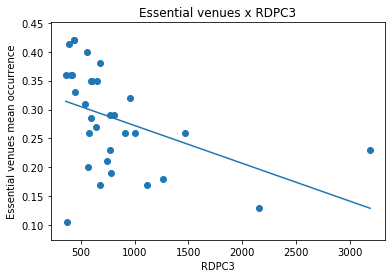

Correlation coefficient: -0.4302202220597623
P-value: 0.013980698277816063


In [20]:
x = key_indicators_organized['RDPC3']
y = essential

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Essential venues x RDPC3')  
plt.xlabel('RDPC3')  
plt.ylabel('Essential venues mean occurrence')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))


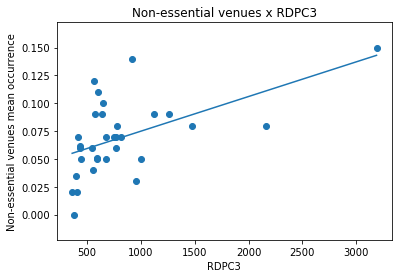

Correlation coefficient: 0.5341476326213365
P-value: 0.0016389213871035233


In [21]:
x = key_indicators_organized['RDPC3']
y = non_essential

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Non-essential venues x RDPC3')  
plt.xlabel('RDPC3')  
plt.ylabel('Non-essential venues mean occurrence')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))

A similar picture results from the plots below, used to plot the venues distribution against the GINI coefficient:

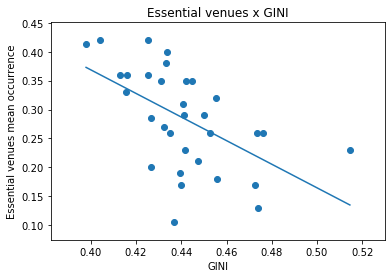

Correlation coefficient: -0.5516855657504257
P-value: 0.0010637897560003863


In [22]:
x = key_indicators_organized['GINI']
y = essential

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Essential venues x GINI')  
plt.xlabel('GINI')  
plt.ylabel('Essential venues mean occurrence')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))


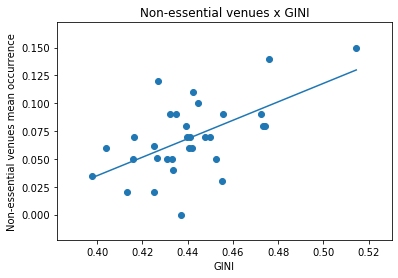

Correlation coefficient: 0.585002962367823
P-value: 0.0004370957546678346


In [23]:
x = key_indicators_organized['GINI']
y = non_essential

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Non-essential venues x GINI')  
plt.xlabel('GINI')  
plt.ylabel('Non-essential venues mean occurrence')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))

The similarity between the results for GINI and RDPC3 can be explained if these two variables are plotted against one another – a clear, positive correlation is found, as shown by the results of the code below. This is explained by the fact that no neighborhood in Sao Paulo is wealthy in absolute numbers – that is, unfortunately there are poor people living in all of the regions. However, there is indeed regions where the poor are vastly prevalent. So, it can be inferred that regions with lower GINIs (i.e. lower inequality) are more equal because all of the residents are living in poor conditions. Similarly, regions with larger GINIs (i.e. higher inequality) have at the same space poor and rich people living close to one another.

Code:

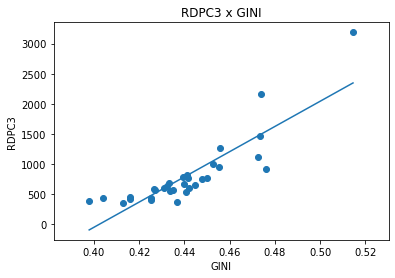

Correlation coefficient: 0.8603864275083101
P-value: 2.7439961788075776e-10


In [24]:
x = key_indicators_organized['GINI']
y = key_indicators_organized['RDPC3']

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('RDPC3 x GINI')  
plt.xlabel('GINI')  
plt.ylabel('RDPC3')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))

A simplified way of compiling the results related to essential and non-essential venues is by using a unified metric, the ratio between essential and non-essential venues. This simplified metric summarizes the idea that wealthy and inequality is moderately correlated with the venues present at each neighborhood. The code below create plots of this summarized variable versus the GINI coefficient and versus GDPC3. Once again, good correlation coefficients and statistical significances were found, confirming the validity of the proposed hypothesis.

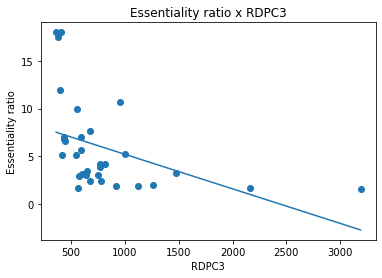

Correlation coefficient: -0.43581678659414197
P-value: 0.012655163952484054


In [25]:
x = key_indicators_organized['RDPC3']
y = essential/non_essential
y[y==np.inf] = 17.5

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Essentiality ratio x RDPC3')  
plt.xlabel('RDPC3')  
plt.ylabel('Essentiality ratio')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))

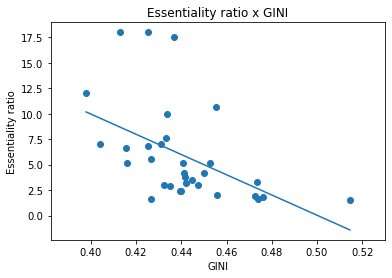

Correlation coefficient: -0.49137101041121956
P-value: 0.004290960208712274


In [26]:
x = key_indicators_organized['GINI']
y = essential/non_essential
y[y==np.inf] = 17.5

p = x.argsort()
x = x[p]
y = y[p]
plt.scatter(x,y)  
plt.title('Essentiality ratio x GINI')  
plt.xlabel('GINI')  
plt.ylabel('Essentiality ratio')  

# linear
m1, b1, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = b1 + m1 * x

plt.plot(x, y_fit, '-')
plt.show()

print("Correlation coefficient: " + str(r_value))
print("P-value: " + str(p_value))

The data exploration shown above supports the hypothesis that there is a clear inequality in the distribution of venues throughout Sao Paulo. Moving forward, the next step was to look for a predictive model that can be used to estimate the wealth level of a neighborhood based on the types of venues found there.

====================================================================

### Modelling

As the number of neighborhoods is relatively small, it is not probable that a regression model will be able to predict figures like the GINI or the GDPC3 based on the venue data. A more reasonable expectation is to look for model able to predict if a neighborhood has a low or high level of income, as a function of the type and count of venues found there. Therefore, the most suitable type of models for this problem are the classifiers. Five different types of classifiers will be evaluated for this problem:
-	support vector machine (SVM), 
-	naive-Bayes, 
-	logistic regression and 
-	k-means classifier
-	multi-layer perceptron (neural network)

The GDPC3 dataset was modified, so that the neighborhoods were classified into 3 categories, as shown below:

In [27]:
x = saopaulo_grouped_means_filtered
key_indicators_classified = key_indicators_organized['RDPC3']*1
key_indicators_classified[key_indicators_classified < 500] = 0
key_indicators_classified[key_indicators_classified > 1000] = 2
key_indicators_classified[key_indicators_classified > 10] = 1
key_indicators_classified

PREFREG
Aricanduva/Formosa/Carrão    1.0
Butantã                      2.0
Campo Limpo                  1.0
Capela do Socorro            1.0
Casa Verde/Cachoeirinha      1.0
Cidade Ademar                1.0
Cidade Tiradentes            0.0
Ermelino Matarazzo           1.0
Freguesia/Brasilândia        1.0
Guaianases                   0.0
Ipiranga                     1.0
Itaim Paulista               0.0
Itaquera                     1.0
Jabaquara                    1.0
Jaçanã/Tremembé              1.0
Lapa                         2.0
M'Boi Mirim                  1.0
Mooca                        1.0
Parelheiros                  0.0
Penha                        1.0
Perus                        0.0
Pinheiros                    2.0
Pirituba/Jaraguá             1.0
Santana/Tucuruvi             1.0
Santo Amaro                  2.0
Sapopemba                    0.0
São Mateus                   0.0
São Miguel                   0.0
Sé                           2.0
Vila Maria/Vila Guilherme    1.0
Vi

Initially, the classifiers were compared in a high level, using default parameters or small variations. The metric used is a manual leave-one-out cross validation, faster to apply and run than the k-fold cross validation:


#### Support vector machine - SVC

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

saopaulo_grouped_means_filtered.index = key_indicators_organized.index
x = saopaulo_grouped_means_filtered
y = key_indicators_classified

for coef in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    results = []
    for i in range(250):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=random.randint(0, 1000))
        model = SVC(C=coef, kernel='linear')
        y_pred = model.fit(x_train,y_train).predict(x_test)
        results.append((y_test != y_pred).sum()/2)
    print(sum(results)/len(results))

0.438
0.422
0.45
0.398
0.408
0.378
0.382
0.382


Best score: 0.45

#### Gaussian Naive-Bayes

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
results = []
for i in range(250):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=random.randint(0, 1000))
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    results.append((y_test != y_pred).sum()/2)
print(sum(results)/len(results))

0.4


Best score: 0.4

#### Logistic regression

In [31]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
for coef in [0.01,0.1,1,10,100,1000]:
    results = []
    for i in range(250):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=random.randint(0, 1000))
        clf = LogisticRegression(solver='liblinear', random_state=0, C=coef).fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        results.append((y_test != y_pred).sum()/2)
    print(sum(results)/len(results))

0.344
0.416
0.428
0.47
0.512
0.464


Best score: 0.512

#### K-means classifier

In [32]:
from sklearn.neighbors import KNeighborsClassifier
for k in range(25):
    results = []
    neigh = KNeighborsClassifier(n_neighbors=k+1)
    for i in range(250):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=random.randint(0, 1000))
        clf = neigh.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        results.append((y_test != y_pred).sum()/2)
    print(sum(results)/len(results))

0.56
0.428
0.486
0.418
0.478
0.384
0.386
0.29
0.414
0.382
0.428
0.352
0.41
0.424
0.438
0.43
0.39
0.382
0.462
0.438
0.442
0.414
0.438
0.424
0.402


Best score: 0.56 (for k=2)

#### Neural Network - MLP Classifier

In [34]:
from sklearn.neural_network import MLPClassifier

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for al in [0.000001,0.00001,0.0001,0.001]:
    results = []
    for i in range(250):
        clf = MLPClassifier(solver='adam', alpha=al,hidden_layer_sizes=(5,5,5,5,5,5), learning_rate_init=0.0001, random_state=random.randint(0, 1000))
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=random.randint(0, 1000))
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results.append((y_test != y_pred).sum()/2)
    print(sum(results)/len(results))

0.684
0.604
0.632
0.628


Best score: 0.684

The best scores were found for the k-means classifier and the MLP neural network models. These are the two models that will be explored in further detail below.

#### Neural Network - MLP Classifier - First refining iteration

Initially, a broader search was done in the three parameters that show the largest influence in the outcome of the neural network:

-	Number of hidden layers
-	Number of nodes per hidden layer
-	Initial learning rate

Here, along with the leave-one-out score, the cross-validation score is also taken into account:

In [100]:
from sklearn.model_selection import cross_val_score

results = []

saopaulo_grouped_means_filtered.index = key_indicators_organized.index
x = saopaulo_grouped_means_filtered
y = key_indicators_classified

tests = [[(2,2),1e-5],
         [(10,10),1e-5],
         [(2,2,2),1e-5],
         [(10,10,10),1e-5],
         [(2,2,2,2),1e-5],
         [(10,10,10,10),1e-5],
         [(2,2,2,2,2),1e-5],
         [(10,10,10,10,10),1e-5],
         [(2,2),1e-4],
         [(10,10),1e-4],
         [(2,2,2),1e-4],
         [(10,10,10),1e-4],
         [(2,2,2,2),1e-4],
         [(10,10,10,10),1e-4],
         [(2,2,2,2,2),1e-4],
         [(10,10,10,10,10),1e-4],
         [(2,2),1e-6],
         [(10,10),1e-6],
         [(2,2,2),1e-6],
         [(10,10,10),1e-6],
         [(2,2,2,2),1e-6],
         [(10,10,10,10),1e-6],
         [(2,2,2,2,2),1e-6],
         [(10,10,10,10,10),1e-6]]
for test in tests:
    cv = 0
    for i in range(50):
        clf = MLPClassifier(solver='adam',hidden_layer_sizes=test[0], learning_rate_init=test[1], random_state=random.randint(0, 1000))
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=random.randint(0, 1000))
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results.append((y_test != y_pred).sum())
        cv += sum(cross_val_score(clf, x, y, cv=5))/5
    print(sum(results)/len(results))
    print(cv/50)
    print()

0.6
0.35352380952380935

0.65
0.32114285714285706

0.6533333333333333
0.3195238095238093

0.645
0.35552380952380935

0.652
0.3266666666666664

0.6633333333333333
0.35009523809523785

0.6714285714285714
0.2931428571428569

0.6825
0.36009523809523813

0.6711111111111111
0.3378095238095236

0.66
0.44076190476190485

0.6654545454545454
0.3485714285714283

0.6566666666666666
0.48257142857142854

0.6569230769230769
0.3756190476190475

0.6471428571428571
0.44542857142857145

0.6493333333333333
0.2943809523809521

0.6375
0.42390476190476195

0.6423529411764706
0.3060952380952379

0.6411111111111111
0.34809523809523796

0.6473684210526316
0.3407619047619046

0.643
0.33657142857142835

0.6457142857142857
0.32780952380952366

0.6454545454545455
0.30866666666666664

0.6443478260869565
0.33790476190476154

0.6425
0.35771428571428565



The results with best compromise between the leave one out and the cross validation scores were those with 10 nodes per hidden layer and initial learning rate around 1e-4. Let's narrow our range of these parameters, while still changing considerably the number of hidden layers:

In [129]:
from sklearn.model_selection import cross_val_score

results = []

saopaulo_grouped_means_filtered.index = key_indicators_organized.index
x = saopaulo_grouped_means_filtered
y = key_indicators_classified

tests = [[(20,20),8e-5],
         [(10,10),8e-5],
         [(20,20,20),8e-5],
         [(10,10,10),8e-5],
         [(20,20,20,20),8e-5],
         [(10,10,10,10),8e-5],
         [(20,20,20,20,20),8e-5],
         [(10,10,10,10,10),8e-5],
         [(20,20),1e-4],
         [(10,10),1e-4],
         [(20,20,20),1e-4],
         [(10,10,10),1e-4],
         [(20,20,20,20),1e-4],
         [(10,10,10,10),1e-4],
         [(20,20,20,20,20),1e-4],
         [(10,10,10,10,10),1e-4],
         [(20,20),2e-4],
         [(10,10),2e-4],
         [(20,20,20),2e-4],
         [(10,10,10),2e-4],
         [(20,20,20,20),2e-4],
         [(10,10,10,10),2e-4],
         [(20,20,20,20,20),2e-4],
         [(10,10,10,10,10),2e-4]]
for test in tests:
    cv = 0
    for i in range(50):
        clf = MLPClassifier(solver='adam',hidden_layer_sizes=test[0], learning_rate_init=test[1], random_state=random.randint(0, 1000))
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=random.randint(0, 1000))
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        results.append((y_test != y_pred).sum())
        cv += sum(cross_val_score(clf, x, y, cv=10))/10
    print(sum(results)/len(results))
    print(cv/50)
    print()

0.54
0.48816666666666686

0.55
0.4158333333333333

0.5466666666666666
0.5211666666666666

0.55
0.46699999999999997

0.54
0.5053333333333332

0.5366666666666666
0.40649999999999986

0.5228571428571429
0.5539999999999999

0.515
0.44516666666666665

0.5066666666666667
0.5181666666666667

0.528
0.42283333333333334

0.5236363636363637
0.5171666666666667

0.5216666666666666
0.4726666666666667

0.52
0.5455

0.5185714285714286
0.4766666666666665

0.5186666666666667
0.535

0.5275
0.42149999999999993

0.5164705882352941
0.5640000000000001

0.5133333333333333
0.5183333333333332

0.5073684210526316
0.6033333333333334

0.509
0.5436666666666666

0.5028571428571429
0.6029999999999999

0.5036363636363637
0.5038333333333334

0.5
0.6026666666666667

0.49916666666666665
0.522



The best results compromise between the leave one out and the cross validation scores were obtained for the following sets of values:

Hidden layers = 3  /  Nodes per hidden layer = 20   /   Initial learning rate = 2e-4
------------------------------> cross-val score = 0.6033  /   leave-one-out score = 0.507

Hidden layers = 4  /  Nodes per hidden layer = 20   /   Initial learning rate = 2e-4
------------------------------> cross-val score = 0.6030  /   leave-one-out score = 0.503

Hidden layers = 5  /  Nodes per hidden layer = 20   /   Initial learning rate = 2e-4
------------------------------> cross-val score = 0.6027  /   leave-one-out score = 0.500

#### Finally, let's also include cross validation in the k-means model and check the results:

In [154]:
from sklearn.neighbors import KNeighborsClassifier
results = []
neigh = KNeighborsClassifier(n_neighbors=2)
cv = 0
for i in range(500):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.02, random_state=random.randint(0, 1000))
    clf = neigh.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    #print(y_pred)
    #print(y_test)
    #print()
    results.append((y_test == y_pred).sum())
    cv += sum(cross_val_score(clf, x, y, cv=10))/10
    #print(cv)
print(cv/500)
print(sum(results)/len(results))

0.6083333333333305
0.574


Final result for k-means: cross-val score of 0.61, leave-one-out score of 0.574